In [1]:
from langchain_ollama import ChatOllama

local_llm = "llama3.1"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [2]:
import os
dirname = "../data/parse/text"

os.listdir(dirname)

['Huong dan quy trinh phat trien dang vien.txt',
 'QC tuyển sinh ĐH 2023_Final_1952023.txt',
 'QD 2891 ĐUK, ngay 23112023 ve danh gia can bo LDQL (PH).txt',
 'Quy che quan ly su dung tai san ĐHBKHN.txt',
 'Quy chế Dân chủ.txt',
 'Quy chế Quản lý tài chính.txt',
 'Quy chế Tổ chức và hoạt động.txt',
 'Quy dinh QL HĐHTĐN_HUST.txt',
 'Quy định QLSV nước ngoài 2023.txt',
 'Quy định tổ chức thi tiếng Anh nội bộ.txt',
 'quy định đánh giá các tổ chức cơ sở đảng trực thuộc đảng ủy khối.txt',
 'Quyết đinh ban hành quy chế đào tạo 2023.txt',
 'QĐ Học bổng KKHT 2023.txt',
 'QĐ Học bổng Trần Đại Nghĩa 2023.txt',
 'QĐ miễn giảm học phí 2023.txt',
 'QĐ Quản lý câu lạc bộ sinh viên 2023.txt',
 'QĐ thi Olympic và ĐMST 2023.txt',
 'QĐ đánh giá điểm rèn luyện sinh viên 2023.txt']

# RAG

## VectorDB ingestion

In [4]:
import weaviate

client = weaviate.connect_to_local()

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_weaviate import WeaviateVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
# from langchain_community.vectorstores import Weaviate
import os
dirname = "../data/parse/text"
text_dir = os.listdir(dirname)
# full_path_dir = "/".join(dirname, )
# Load documents

docs = [TextLoader(os.path.join(dirname, file)).load() for file in text_dir]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1024, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = WeaviateVectorStore.from_documents(
    client=client,
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings(model_name="BAAI/bge-m3",),
    index_name="Hust_doc"
)

# Create retriever
retriever = vectorstore.as_retriever(k=3)


g:\anaconda\anaconda3\envs\chatbot-agent\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Router

In [6]:
### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or a SQL store or a websearch.

The vectorstore contains documents related to Hanoi University of Science & Technology.

Use the vectorstore for questions on these topics. For questions related to teachers that include names, use the SQL store. For other questions, use the websearch tool.

Return JSON with single key, datasource, that is 'sql' or 'vectorstore' or 'irrelevant' depending on the question."""

# Test router
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [
        HumanMessage(
            content="Nguyễn Kiêm Hiếu"
        )
    ]
)
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="Phương thức tuyển sinh của bách khoa gồm những gì")]
)
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="Vượt đèn đỏ bị phạt bao nhiêu tiền?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search_2.content),
    json.loads(test_vector_store.content),
)

{'datasource': 'sql'} {'datasource': 'vectorstore'} {'datasource': 'websearch'}


## Grader

In [7]:
# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. Both the documents and question will be in Vietnamese."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "Bài giải tích này giải như nào?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'no'}

## Main

In [8]:
# Prompt
rag_prompt = """You are an expert for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context.

Keep the answer concise, detailed and ALWAYS USE VIETNAMESE TO RESPOND.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

question = "Tiêu chuẩn xét cấp học bổng khuyến khích học tập"
# Test
# Retrieve
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Tiêu chuẩn xét cấp học bổng khuyến khích học tập như sau:

- Học bổng loại C: GPA ≥ 2,5 và điểm rèn luyện học kỳ ≥ 65 điểm.
- Học bổng loại B: GPA ≥ 3,2 và điểm rèn luyện học kỳ ≥ 80 điểm.
- Học bổng loại A: GPA ≥ 3,6 và điểm rèn luyện học kỳ ≥ 90 điểm.

Học bổng được xét theo khóa, ngành đào tạo và theo thứ tự ưu tiên lần lượt từ loại A đến loại C, từ điểm GPA cao cho đến điểm GPA thấp cho đến khi hết quỹ học bổng.


In [9]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': 'Tiêu chuẩn xét cấp học bổng khuyến khích học tập được đề cập trong cả hai văn bản (FACTS và STUDENT ANSWER). Cả hai đều quy định về các loại học bổng (loại A, B, C) và tiêu chí để đạt được mỗi loại. Do đó, STUDENT ANSWER là đúng.'}

# Web Search

In [10]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")
    # 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

In [11]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# SQL

## Database creation

In [12]:
from sqlalchemy import (
    create_engine,
    MetaData,
    Table,
    Column,
    String,
    Integer,
)

from langchain_community.utilities import SQLDatabase

engine = create_engine("sqlite:///:memory:", future=True)
metadata_obj = MetaData()

# create city SQL table
table_name = "teacher"
teacher_table = Table(
    table_name,
    metadata_obj,
    Column("name", String(16), primary_key=True),
    Column("subjects", String(16)),
)

metadata_obj.create_all(engine)
db=SQLDatabase(engine=engine, include_tables=['teacher'])

In [13]:
from sqlalchemy import insert

rows = [
    {"name": "Đinh Viết Sang", "subjects": "Thị giác máy tính"},
    {"name": "Đặng Tuấn Linh", "subjects": "Học sâu"},
    {"name": "Nguyễn Kiêm Hiếu", "subjects": "Web Mining"}
]
for row in rows:
    stmt = insert(teacher_table).values(**row)
    with engine.begin() as connection:
        cursor = connection.execute(stmt)

with engine.connect() as connection:
    cursor = connection.exec_driver_sql("SELECT * FROM teacher")
    print(cursor.fetchall())

[('Đinh Viết Sang', 'Thị giác máy tính'), ('Đặng Tuấn Linh', 'Học sâu'), ('Nguyễn Kiêm Hiếu', 'Web Mining')]


In [14]:
print(db.dialect)
print(db.get_usable_table_names())
try:
    db.run("SELECT * FROM table;")
except:
    print("Error")

sqlite
['teacher']
Error


## SQL rewrite

In [15]:

sql_instruction = """
You are an expert in question-answering tasks.

You will be given a question relating to a person/teacher of Hanoi University of Science & Technology.

The database tables are {table_list}, with each tables attributes are name and subjects.

Your job is to rewrite the question into a SQL query. Return a JSON format with a single key, sql_query, with the result query as its value.
"""

sql_prompt = sql_instruction.format(table_list=db.get_usable_table_names())
test_sql_search = llm_json_mode.invoke(
    [SystemMessage(content=sql_prompt)]
    + [
        HumanMessage(
            content="Có những giảng viên nào dạy môn thị giác máy tính"
        )
    ]
)

print(json.loads(test_sql_search.content))

{'sql_query': "SELECT name FROM teacher WHERE subjects = 'Thị giác máy tính'"}


## SQL Checker

In [16]:
sql = json.loads(test_sql_search.content)
try:
   response = db.run(sql['sql_query'])
   print(len(response))
   print(response)
except:
    print("NONE")

21
[('Đinh Viết Sang',)]


## Reponse generation

In [17]:
sql_answer_prompt ="""
You are an expert in questions-answering tasks.

You are given a question from the user and an output from a SQL query.

Your job is to generate an answer based on the question and the query result. If there is no SQL output, simply ask the user to ask again.

Keep the answer consise and ALWAYS RESPOND IN VIETNAMESE.

Question: {question}.
SQL Query: {query}.
SQL Query Output: {output}.

Answer:
"""

sql_answer_prompt_format = sql_answer_prompt.format(question="Có những giảng viên nào dạy môn thị giác máy tính",
                                                    query=sql['sql_query'],
                                                    output=response)

sql_output = llm.invoke(
    [HumanMessage(content=sql_answer_prompt_format)]
)
print(sql_output)

content='Giảng viên Đinh Viết Sang là người dạy môn Thị giác máy tính.' additional_kwargs={} response_metadata={'model': 'llama3.1', 'created_at': '2024-12-09T08:50:56.7637047Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 6353399700, 'load_duration': 30258400, 'prompt_eval_count': 130, 'prompt_eval_duration': 1852719000, 'eval_count': 18, 'eval_duration': 4467973000} id='run-33f9b09d-4da2-4185-9e77-1de8cfb9afa7-0' usage_metadata={'input_tokens': 130, 'output_tokens': 18, 'total_tokens': 148}


# Graph

In [18]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    sql_query: str  # Binary decision to run web search
    sql_result: str
    end: str # Decision to end the conversation
    web_search: str
    sql: bool # Tag to decide SQL generation or RAG
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents


In [48]:
from langchain.schema import Document
from langgraph.graph import END
import asyncio

### Nodes
async def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = await retriever.ainvoke(question)
    return {"documents": documents, "sql": False}


async def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    if state['sql']:
        print("---GENERATION FOR SQL---")
        query = state['sql_query']
        sql_result = state['sql_result']
        sql_answer_prompt_format = sql_answer_prompt.format(question=question,
                                                    query=query,
                                                    output=sql_result)
        sql_output = await llm.ainvoke(
            [HumanMessage(content=sql_answer_prompt_format)]
        )
        return {"generation": sql_output, "loop_step": loop_step + 1}
    documents = state["documents"]
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = await llm.ainvoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}

async def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = await web_search_tool.ainvoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, 'sql': False}


async def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated end state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    websearch = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = await llm_json_mode.ainvoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            # websearch = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": websearch}

async def rewrite(state):
    """
    
    Rewrite user query into SQL command

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The SQL query
    """
    print("---REWRITING QUERY TO SQL---")
    sql_prompt = sql_instruction.format(table_list=db.get_usable_table_names())
    question = state["question"]
    result = await llm_json_mode.ainvoke(
        [SystemMessage(content=sql_prompt)]
        + [
            HumanMessage(
                content=question
            )
        ]
    )
    query = json.loads(result.content)
    return {"sql_query": query['sql_query'], "sql": True}

async def run_sql(state):
    """
    
    Run the SQL command and check if feasible.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Output of SQL query

    """
    print("---RUNNING SQL QUERY---")
    query = state['sql_query']
    try:
        response = await db.run(query)
    except:
        response = None
    
    return {"sql_result": response}

# EDGES
def check_sql(state):
    """
    Determines whether to generate or use web_search

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print("---CHECKING SQL RESULT---")
    response = state["sql_result"]
    if response:
        return "result found"
    return  "no result"

async def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = await llm_json_mode.ainvoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "sql":
        print("---ROUTE QUESTION TO SQL---")
        # state['sql'] = True
        return "sql"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        # state['sql'] = False
        return "vectorstore"
    else:
        print('---ROUTE QUESTION TO WEBSEARCH---')
        return 'irrelevant'

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    # question = state["question"]
    web_search = state["web_search"]
    # filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


async def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    if state['sql']:
        return 'useful'
    
    print("---CHECK HALLUCINATIONS---")
    # question = state["question"]
    
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided
    if not state['sql']:
        documents = state["documents"]
        hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
            documents=format_docs(documents), generation=generation.content
        )
    else:
        query_result = state["sql_result"]
        hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
            documents=query_result, generation=generation.content
        )
    result = await llm_json_mode.ainvoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "useful"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "unanswerable"
    # elif state["loop_step"] <= max_retries:
    #     print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
    #     return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

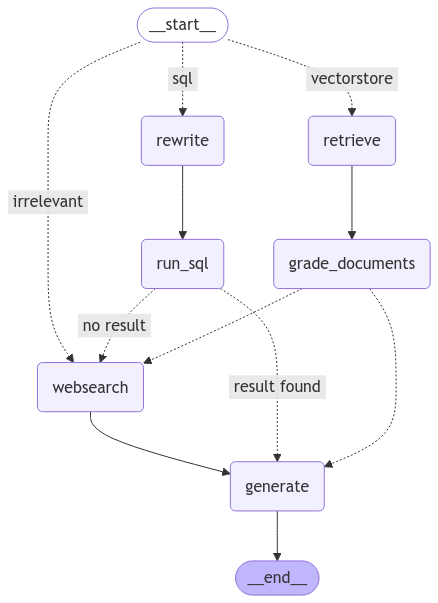

In [49]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("rewrite", rewrite)  # web search
workflow.add_node("run_sql", run_sql)
# workflow.add_node("sql_answer", sql_answer)
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("websearch", web_search)

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "sql": "rewrite",
        "vectorstore": "retrieve",
        "irrelevant": "websearch",
    },
)
workflow.add_edge("rewrite", "run_sql")
# workflow.add_edge("run_sql", "generate")
workflow.add_conditional_edges(
    "run_sql",
    check_sql,
    {
        "result found": "generate",
        "no result": "websearch",
    }
)

# workflow.add_edge("sql_answer", END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("generate", END)
# workflow.add_conditional_edges(
#     "generate",
#     grade_generation_v_documents_and_question,
#     {
#         # "not supported": "generate",
#         "useful": END,
#         "unanswerable": "generate",
#         "max retries": END,
#     },
# )
workflow.add_edge("websearch", "generate")
# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [50]:
inputs = [{"question": "Tiêu chuẩn xét cấp học bổng khuyến khích học tập", "max_retries": 3}, 
          {"question": "Tiêu chuẩn xét cấp học bổng trần đại nghĩa", "max_retries": 3}]
calls = [
    graph.ainvoke(input=inputs[0]),
    graph.ainvoke(input=inputs[1])
]
outputs = await asyncio.gather(*calls)

---ROUTE QUESTION---
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


In [55]:
test = await asyncio.gather(graph.ainvoke(input=inputs[0]))

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


In [ ]:
inputs = {"question": "đinh viết sang", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)
print("---------")
print(event['generation'].content)

---ROUTE QUESTION---
---ROUTE QUESTION TO SQL---
{'question': 'đinh viết sang', 'max_retries': 3, 'loop_step': 0}
---REWRITING QUERY TO SQL---
{'question': 'đinh viết sang', 'sql_query': "SELECT * FROM teacher WHERE name = 'Đinh Viết Sang'", 'sql': True, 'max_retries': 3, 'loop_step': 0}
---RUNNING SQL QUERY---
---CHECKING SQL RESULT---
{'question': 'đinh viết sang', 'sql_query': "SELECT * FROM teacher WHERE name = 'Đinh Viết Sang'", 'sql_result': "[('Đinh Viết Sang', 'Thị giác máy tính')]", 'sql': True, 'max_retries': 3, 'loop_step': 0}
---GENERATE---
---GENERATION FOR SQL---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---
{'question': 'đinh viết sang', 'generation': AIMessage(content='Giáo viên Đinh Viết Sang chuyên môn về thị giác máy tính.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-21T10:13:28.1604443Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reas

In [ ]:
inputs = {"question": "Con bò có mấy cái chân", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)
print("---------")
print(event['generation'].content)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEBSEARCH---
{'question': 'Con bò có mấy cái chân', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'Con bò có mấy cái chân', 'sql': False, 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Mục đích câu hỏi là hỏi về con bò, con bò có mấy chân, con bò có 4 chân: 6: ... Con bò: 7: Có 10 con bò và 9 cái chuồng. Hỏi xây làm sao mà mỗi con 1 chuồng, không được 1 chuồng 2 con và không có con nào ở ngoài? Xây các chuồng bò thành hình tam giác, mỗi cạnh 3 chuồng, con thứ\nCon trả lời là 5. - Bò chỉ có 4 chân thôi mà? - Tũn tròn mắt. Cậu con trai nhún vai: - Nhưng con là người đưa ra đáp án gần đúng nhất! - !!! Tất Nhiên (st) Trở lại Thư giãn Trở lại Thư giãn. Thấy cậu con trai trở về với chiếc nơ xanh trên cổ tay, Tũn hỏi: - VnExpress.\nĐáp án: Con bò này cưỡi lên lưng con bò kia theo vòng tròn nên mỗi con chỉ có 2 chân. Đó là lý do vì sao khi bạn nhìn thấy 6 con bò lại chỉ đếm thấy có 12 cái chân. Đọc

In [ ]:
# 1
x = "lala"
y = 2
z = {'a': 'b'}